## Notebook for analyzing experimental results. 

This notebook provides an example of how to parse experimental logs. 


In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
# 
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree



import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
import math
sys.path.append('./analysis_helper/')

from db import ExperimentDatabase
from datetime import datetime

def filterit(sub):
    try:
        sub['last_epoch'] = sub['last_epoch'] * sub['n_gpu_per_node']
    except:
        pass
    try: 
        gpus = sub['n_gpu_per_node'] if 'n_gpu_per_node' in sub.columns else exps.all_args['n_gpu_per_node']
        N = sub["N"] if 'N' not in exps.all_args else exps.all_args['N']
        if 'batch_size' in exps.all_args:
            sub['logSamples'] = np.round(np.log2(((sub['last_epoch']+1) * exps.all_args['epoch_size'])), decimals=2)
        else:
            sub['logSamples'] = np.round(np.log2(((sub['last_epoch']+1) * sub['epoch_size'])), decimals=2)
    except:
        pass

    return sub

In [4]:
# Parameters are (1) a list of experiment names whose log files you want to parse and (2) the path to the parent folder of these experiments.
exps = ExperimentDatabase(path='../checkpoint/', xp_list=['example'], xp_selector=['test_run'], has_beam=True, verbose=True)

['example']
[('example', 'test_run')]
['../checkpoint/example/test_run']
['../checkpoint/example/test_run'] 1 experiments found
1 pickled experiments found

common args
exp_name = demo-salsa
save_periodic = 0
exp_id = 66572380
fp16 = False
amp = -1
enc_emb_dim = 1024
dec_emb_dim = 512
n_enc_layers = 2
n_dec_layers = 2
n_enc_heads = 16
n_dec_heads = 4
n_enc_hidden_layers = 1
n_dec_hidden_layers = 1
xav_init = False
gelu_activation = False
norm_attention = False
dropout = 0
attention_dropout = 0
share_inout_emb = False
sinusoidal_embeddings = False
enc_loop_idx = 1
dec_loop_idx = 1
enc_loops = 2
dec_loops = 8
gated = True
enc_gated = False
dec_gated = False
scalar_gate = False
enc_act = False
dec_act = False
act_threshold = 0.01
act_ponder_coupling = 0.05
env_base_seed = 0
max_len = 512
batch_size = 128
batch_size_eval = 64
optimizer = adam_warmup,lr=0.00001,warmup_updates=8000,weight_decay=0.99
weighted_loss = False
clip_grad_norm = 5
epoch_size = 300000
max_epoch = 100000
stopping_crit

In [5]:
exps.all_args

{'dump_path': '/checkpoint/fcharton//dumped/demo-salsa/66572380',
 'exp_name': 'demo-salsa',
 'save_periodic': 0,
 'exp_id': '66572380',
 'fp16': False,
 'amp': -1,
 'enc_emb_dim': 1024,
 'dec_emb_dim': 512,
 'n_enc_layers': 2,
 'n_dec_layers': 2,
 'n_enc_heads': 16,
 'n_dec_heads': 4,
 'n_enc_hidden_layers': 1,
 'n_dec_hidden_layers': 1,
 'xav_init': False,
 'gelu_activation': False,
 'norm_attention': False,
 'dropout': 0,
 'attention_dropout': 0,
 'share_inout_emb': False,
 'sinusoidal_embeddings': False,
 'enc_loop_idx': 1,
 'dec_loop_idx': 1,
 'enc_loops': 2,
 'dec_loops': 8,
 'gated': True,
 'enc_gated': False,
 'dec_gated': False,
 'scalar_gate': False,
 'enc_act': False,
 'dec_act': False,
 'act_threshold': 0.01,
 'act_ponder_coupling': 0.05,
 'env_base_seed': 0,
 'max_len': 512,
 'batch_size': 128,
 'batch_size_eval': 64,
 'optimizer': 'adam_warmup,lr=0.00001,warmup_updates=8000,weight_decay=0.99',
 'weighted_loss': False,
 'clip_grad_norm': 5,
 'epoch_size': 300000,
 'max_epo

In [6]:
## subset = exps.filter_exp({})
subset = exps.db.sort_values(by='best_acc')

possible_cols = ['exp_name','exp_id', 'end_time','samples', 'ended','error', 'secret', 'recover_method','optimizer','start_time', 'batch_size', 'best_prop_ones', 'best_total_prop', 'percs_diff','idx_best_prop_ones','N', 'Q', 'K', 'percQ_bound', 'percQ_increase', 'maxQ_prob', 'reuse', 'times_reused', 'input_int_base', 'output_int_base', 'num_secrets_per_size', 'secret_sizes', 'sigma', 'hamming', 'sparsity', 'n_enc_heads', 'n_dec_heads','n_enc_layers', 'n_dec_layers', 'enc_emb_dim', 'dec_emb_dim', 'enc_loops', 'dec_loops', 'enc_loop_idx','gated', 'secret_found', 'best_percs_diff', 'last_percs_diff',  'best_bitwise_acc','best_acc', 'last_acc', 'weighted_loss', 'best_epoch', 'last_epoch', 'freeze_embeddings','oom', 'reload_model', 'multi_gpu', 'n_gpu_per_node']
cols = []
for p in possible_cols:
    if p in subset.columns:
        cols.append(p)

sub = filterit(subset[cols].sort_values(by='best_acc', ascending=False))
reuse = 1 if exps.all_args['reuse']==True else 0
sub['adjSamples'] = np.round(sub['logSamples'] - reuse * np.log2(exps.all_args['K']*exps.all_args['times_reused']), 2)#,0)).astype(int)
sub['recover_method'] = sub['recover_method'].apply(lambda x: x[0] if len(x)>0 else  '')

#sub  = sub[sub['oom']!=1]
def f(x, idx):
    if (len(x) >= idx) and (idx >= 0):
        return np.round(x[idx][0],2)
    return 0

sub['hamming'] = sub['secret'].apply(lambda x: np.sum(x))
exps.print_table(sub[['hamming','adjSamples','secret_found', 'recover_method','best_acc']][sub['secret_found']==True].sort_values(by='adjSamples', ascending=True)) #[(sub['hamming']>2)]) #[(sub['N']==50) & (sub['enc_loops']==8)])#_values(by='percQ_bound')) #[(sub['error']==True) & (sub['N']==70)]) #[sub['hamming']>5]==


+---+---------+------------+--------------+----------------+----------+
|   | hamming | adjSamples | secret_found | recover_method | best_acc |
+---+---------+------------+--------------+----------------+----------+
| 0 |    3    |   17.87    |     True     |       92       |   1.92   |
+---+---------+------------+--------------+----------------+----------+


In [7]:
pd.pivot_table(data=sub[sub['secret_found']==True], index='N', values='adjSamples')

,adjSamples
N,17.87


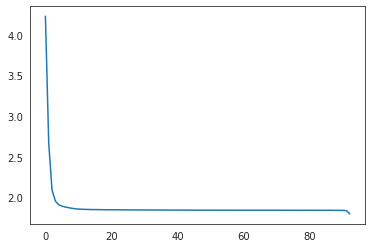

In [8]:
exps.training_curve('train_loss', subset) #[subset['hamming']==5])#subset['exp_id']=='52287851']) #[subset['exp_id']=='52308100']) #[subset['exp_id']=='52283730']) #[subset['hamming']==5]) #[subset['exp_id']=='52208597']) #[subset['exp_id']=='52283739'])#[subset['N']==70]) #[subset['hamming']==5]) #[(subset['hamming']==4) & (subset['error']==True)])#[subset['N']>30]) #[subset['hamming']==5])#[subset['N']==50]) #[subset['exp_id']=='51904209'])
